In [ ]:
from os.path import join
import sys
import glob

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind
import seaborn as sns

import statsmodels.api as sm

# sns.set(font_scale = 1.5)
sns.set_context('talk')
import pandas as pd
import datetime
%matplotlib inline

## Extract Data

In [ ]:
# loading data from google spreadsheet
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

from google.colab import drive
drive.mount('/content/drive')

save_dir = '/content/drive/Shareddrives/TuriLab/Data/PTSD_project/!analysis/saveFolder/noELS/figures/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
worksheet = gc.open('all_cohorts_freezing_FINAL').sheet1
# get_all_values gives a list of rows.
data = worksheet.get_all_values()

# Convert to a DataFrame and render.
import pandas as pd
df = pd.DataFrame.from_records(data)
df.columns = df.iloc[0]
df.drop(df.index[0], inplace=True)
df.reset_index(inplace=True, drop=True)

# swapping out 'ptsd' to sefl in condition column
df.loc[:,('condition')].replace('ptsd','SEFL', inplace=True)
# replacing NA to NaN
df.replace('NA', np.NaN, inplace=True)
# changing `freezing` dtype to float
df['freezing'] = pd.to_numeric(df['freezing'],
                                        downcast='float')
# adding unique ID-s based on `id` and `cohort`
df['cohort_id']= df['cohort']+'_'+df['id']

df['date_time'] = df['date']+' '+df['time']
df['man_date_time'] = pd.to_datetime(df['date_time'])

df['date'] = df['date'].astype('datetime64[ns]', copy=False)
df.set_index(['cohort_id', 'sex', 'els',
                     'genotype'], inplace=True)

df.head()

,,,,freezing,id,day,condition,cohort,exposure_mins,analyzed_duration,date,time,date_time,man_date_time
cohort_id,sex,els,genotype,,,,,,,,,,,
ptsd1_5HT2Afl05a-5,male,n,2aFlox_het,3.510000,5HT2Afl05a-5,sefla,control,ptsd1,60,60,2021-04-03,1:34 PM,4/3/2021 1:34 PM,2021-04-03 13:34:00
ptsd1_5HT2Afl05a-7,male,n,wt,3.080000,5HT2Afl05a-7,sefla,control,ptsd1,60,60,2021-04-03,1:34 PM,4/3/2021 1:34 PM,2021-04-03 13:34:00
ptsd1_5HT2ACre01a-3,male,n,wt,0.800000,5HT2ACre01a-3,sefla,control,ptsd1,60,60,2021-04-03,1:34 PM,4/3/2021 1:34 PM,2021-04-03 13:34:00
ptsd1_sert26a-3,male,n,wt,0.700000,sert26a-3,sefla,control,ptsd1,60,60,2021-04-03,1:58 PM,4/3/2021 1:58 PM,2021-04-03 13:58:00
ptsd1_5HT2Afl5a-6,male,n,wt,45.130001,5HT2Afl5a-6,sefla,SEFL,ptsd1,60,60,2021-04-03,3:03 PM,4/3/2021 3:03 PM,2021-04-03 15:03:00


In [ ]:
worksheet = gc.open('age_at_sefla').sheet1
data = worksheet.get_all_values()
age_at_sefla = pd.DataFrame.from_records(data)
age_at_sefla.columns = age_at_sefla.iloc[0]
age_at_sefla.drop(age_at_sefla.index[0], inplace=True)
age_at_sefla.set_index('cohort_id', inplace=True, drop=True)
# age_at_sefla.drop([''], axis=1, inplace=True)
age_at_sefla['age_at_SEFLA'] = pd.to_numeric(age_at_sefla['age_at_SEFLA'],
                                        downcast='float')

age_at_sefla.head()

,age_at_SEFLA
cohort_id,
ptsd1_5HT2Afl05a-5,16.142857
ptsd1_5HT2Afl05a-7,16.142857
ptsd1_5HT2ACre01a-3,13.285714
ptsd1_sert26a-3,17.714285
ptsd1_5HT2Afl5a-6,16.142857


In [ ]:
worksheet = gc.open('Learing_slopes_pre_sock06').sheet1

# get_all_values gives a list of rows.
data = worksheet.get_all_values()
# print(data)
# Convert to a DataFrame and render.
learning_df = pd.DataFrame.from_records(data)
learning_df.columns = learning_df.iloc[0]
learning_df.drop(learning_df.index[0], inplace=True)
learning_df.reset_index(inplace=True, drop=True)
learning_df.drop([''], axis=1, inplace=True)
learning_df['slope'] = pd.to_numeric(learning_df['slope'],
                                        downcast='float')
learning_df['sex']=learning_df['sex'].str.lower()
learning_df.set_index('cohort_id', inplace=True)
learning_df.head()

,group,sex,els,dob,genotype,slope
cohort_id,,,,,,
els1_921-2,Control,female,n,2021-10-25,wt,0.0176
els1_921-3,Control,female,n,2021-10-25,wt,-0.0034
els1_921-4,Control,female,n,2021-10-25,wt,0.0439
els1_927-1,Control,male,n,2021-10-21,wt,0.4501
els1_927-2,Control,male,n,2021-10-21,wt,-0.2275


merging slope df and age df

In [ ]:
df_merged= learning_df.join(age_at_sefla, how='inner')
df_merged.reset_index(inplace=True)
df_merged.set_index(['cohort_id', 'sex', 'els',
                     'genotype'], inplace=True)

df_merged

,,,,group,dob,slope,age_at_SEFLA
cohort_id,sex,els,genotype,,,,
els1_921-2,female,n,wt,Control,2021-10-25,0.0176,16.714285
els1_921-3,female,n,wt,Control,2021-10-25,-0.0034,16.714285
els1_921-4,female,n,wt,Control,2021-10-25,0.0439,16.714285
els1_927-1,male,n,wt,Control,2021-10-21,0.4501,17.000000
els1_927-2,male,n,wt,Control,2021-10-21,-0.2275,17.000000
...,...,...,...,...,...,...,...
ptsd9_30-2,male,n,wt,Control,2021-10-13,0.5862,13.000000
ptsd9_30-5,male,n,wt,Control,2021-10-13,0.0029,13.000000
ptsd9_31-1,male,n,wt,SEFL,2021-10-13,0.8103,13.000000


In [ ]:
seflb_freez = df[df['day']=='seflb']
joined_seflb = seflb_freez.join(df_merged, how='inner')
joined_seflb.head(1)

,,,,freezing,id,day,condition,cohort,exposure_mins,analyzed_duration,date,time,date_time,man_date_time,group,dob,slope,age_at_SEFLA
cohort_id,sex,els,genotype,,,,,,,,,,,,,,,
ptsd2_83,male,n,wt,16.9,83,seflb,SEFL,ptsd2,3.5,3.5,2021-04-29,4:40 PM,4/29/2021 4:40 PM,2021-04-29 16:40:00,SEFL,2021-02-16,0.6688,10.142858


In [ ]:
recall5_freez = df[df['day']=='recall5']
joined_recall = recall5_freez.join(df_merged, how='inner')
joined_recall.head(1)

,,,,freezing,id,day,condition,cohort,exposure_mins,analyzed_duration,date,time,date_time,man_date_time,group,dob,slope,age_at_SEFLA
cohort_id,sex,els,genotype,,,,,,,,,,,,,,,
ptsd2_83,male,n,wt,8.38,83,recall5,SEFL,ptsd2,5,5,2021-06-02,10:03 AM,6/2/2021 10:03 AM,2021-06-02 10:03:00,SEFL,2021-02-16,0.6688,10.142858


Cleanup:

In [ ]:
df = # put the relevant DF here
clean_df = df[['freezing_recall1', 'condition', 'slope', 'age_at_SEFLA',
               'freezing_seflb']]
clean_df.reset_index(inplace=True)
clean_df.drop(['els', 'genotype'], inplace=True, axis=1) #<- all are wt and non-els
clean_df.set_index('cohort_id', inplace=True)
clean_df['sex'].replace(['male','female'],[0,1],inplace=True)
clean_df.head(2)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


,sex,freezing_recall1,condition,slope,age_at_SEFLA,freezing_seflb
cohort_id,,,,,,
ptsd2_83,0,38.529999,SEFL,0.6688,10.142858,16.90
ptsd2_93,0,24.049999,SEFL,0.6712,10.142858,8.63


In [ ]:
df = j
clean_df = df[['freezing', 'condition', 'slope', 'age_at_SEFLA']]
clean_df.reset_index(inplace=True)
clean_df.drop(['els', 'genotype'], inplace=True, axis=1) #<- all are wt and non-els
clean_df.set_index('cohort_id', inplace=True)
clean_df['sex'].replace(['male','female'],[0,1],inplace=True)
clean_df.head(2)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


,sex,freezing,condition,slope,age_at_SEFLA
cohort_id,,,,,
ptsd2_83,0,8.38,SEFL,0.6688,10.142858
ptsd2_93,0,8.82,SEFL,0.6712,10.142858


# Model: MLR

### All mice

Text(0.5, 1.0, 'Corr Matrix all mice freezing @ recall5')

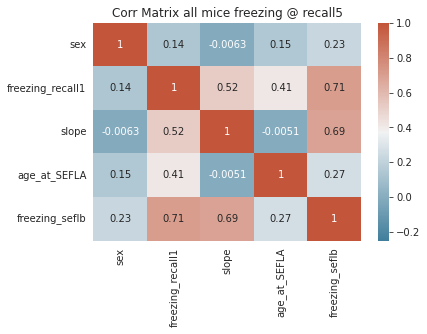

In [ ]:
df= clean_df
cmap = sns.diverging_palette(230, 20, as_cmap=True)
g = sns.heatmap(df.corr(), annot=True, cmap=cmap,
                 vmax=1, vmin=-.25)
g.set_title('Corr Matrix all mice freezing @ recall5')
# plt.savefig(join(save_dir, 'noELS', 'figures','multiReg',
#                  'OLS_corr_matrix_all_mice_recall5.png'),
#                figsize=(5,5), transparent=True, dpi=300,
#                bbox_inches='tight')

### Control Group vs. SEFL

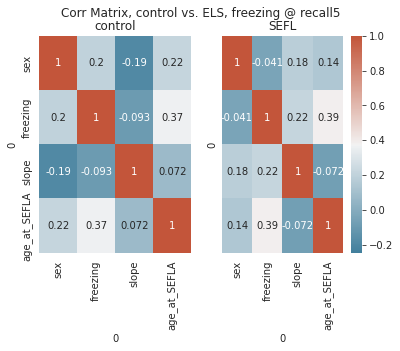

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True
                     )
fig.suptitle('Corr Matrix, control vs. ELS, freezing @ recall5')
df = clean_df[clean_df['condition']=='control']
cmap = sns.diverging_palette(230, 20, as_cmap=True)
vmax=1
vmin=-0.25
g1 = sns.heatmap(df.corr(), annot=True, cmap=cmap, ax=ax[0],
                 vmax=vmax, vmin=vmin, cbar=False)
ax[0].set_title('control')

df = clean_df[clean_df['condition']=='SEFL']
g2 = sns.heatmap(df.corr(), annot=True, cmap=cmap, ax=ax[1],
                 vmax=vmax, vmin=vmin, cbar=True)
ax[1].set_title('SEFL')
plt.savefig(join(save_dir, 'noELS', 'figures','multiReg',
                 'OLS_corr_matrix_by_condition_recall5.png'),
               figsize=(11,5), transparent=True, dpi=300,
               bbox_inches='tight')

### Control group

In [ ]:
df_c = clean_df[clean_df['condition']=='control'].drop('condition', axis=1)
y_c = df_c['freezing']
x_c = df_c.drop('freezing', axis=1)

mlr_c = sm.OLS(y_c, x_c).fit()
print(mlr_c.summary())

                                 OLS Regression Results                                
Dep. Variable:               freezing   R-squared (uncentered):                   0.754
Model:                            OLS   Adj. R-squared (uncentered):              0.722
Method:                 Least Squares   F-statistic:                              23.48
Date:                Mon, 02 May 2022   Prob (F-statistic):                    3.46e-07
Time:                        03:07:56   Log-Likelihood:                         -95.671
No. Observations:                  26   AIC:                                      197.3
Df Residuals:                      23   BIC:                                      201.1
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

### SEFL group

In [ ]:
ldf_s = clean_df[clean_df['condition']=='SEFL'].drop('condition', axis=1)
y_c = df_s['freezing']
x_c = df_s.drop('freezing', axis=1)

mlr_c = sm.OLS(y_c, x_c).fit()
print(mlr_c.summary())

                                 OLS Regression Results                                
Dep. Variable:               freezing   R-squared (uncentered):                   0.753
Model:                            OLS   Adj. R-squared (uncentered):              0.731
Method:                 Least Squares   F-statistic:                              34.59
Date:                Mon, 02 May 2022   Prob (F-statistic):                    1.95e-10
Time:                        03:21:10   Log-Likelihood:                         -146.79
No. Observations:                  37   AIC:                                      299.6
Df Residuals:                      34   BIC:                                      304.4
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

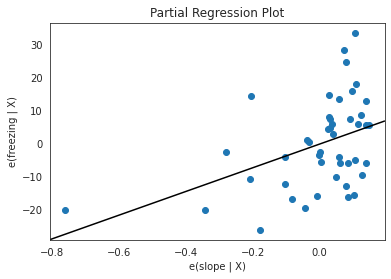

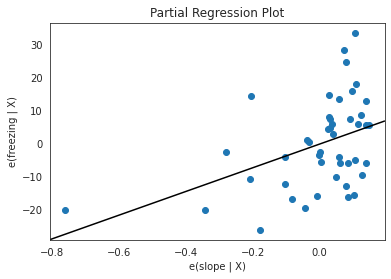

In [ ]:
sm.graphics.plot_partregress('freezing', 'slope', ['sex'],
                             data=df_s, obs_labels=False)

### based on multiple freezing days

In [ ]:
recall5_freez = df[df['day']=='recall5']['freezing'].rename('rec5', inplace=True)
recall1_freez = df[df['day']=='recall1']['freezing'].rename('rec1', inplace=True)
seflb_freez = df[df['day']=='seflb']['freezing'].rename('seflb', inplace=True)

joined = df_merged.join([recall1_freez, recall5_freez, seflb_freez],
                        how='inner')
joined

In [ ]:
joined.head(1)

,,,,group,dob,slope,age_at_SEFLA,rec1,rec5,seflb
cohort_id,sex,els,genotype,,,,,,,
els1_921-2,female,n,wt,Control,2021-10-25,0.0176,16.714285,37.32,15.67,11.7


In [ ]:
df = joined
clean_df = df[['rec1', 'rec5', 'seflb', 'age_at_SEFLA',
               'slope', 'group']]
clean_df.reset_index(inplace=True)
clean_df.drop(['els', 'genotype'], inplace=True, axis=1) #<- all are wt and non-els
clean_df.set_index('cohort_id', inplace=True)
clean_df['sex'].replace(['male','female'],[0,1],inplace=True)
clean_df.head(2)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


,sex,rec1,rec5,seflb,age_at_SEFLA,slope,group
cohort_id,,,,,,,
els1_921-2,1,37.320000,15.67,11.70,16.714285,0.0176,Control
els1_921-3,1,43.700001,15.31,9.22,16.714285,-0.0034,Control


Text(0.5, 1.0, 'Corr Matrix all mice freezing @ recall5')

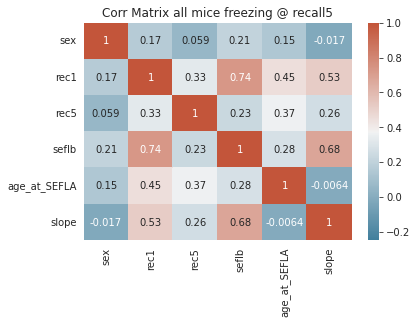

In [ ]:
df= clean_df
cmap = sns.diverging_palette(230, 20, as_cmap=True)
g = sns.heatmap(df.corr(), annot=True, cmap=cmap,
                 vmax=1, vmin=-.25)
g.set_title('Corr Matrix all mice freezing @ recall5')
# plt.savefig(join(save_dir, 'noELS', 'figures','multiReg',
#                  'OLS_corr_matrix_all_mice_recall5.png'),
#                figsize=(5,5), transparent=True, dpi=300,
#                bbox_inches='tight')

Text(0.5, 1.0, 'SEFL')

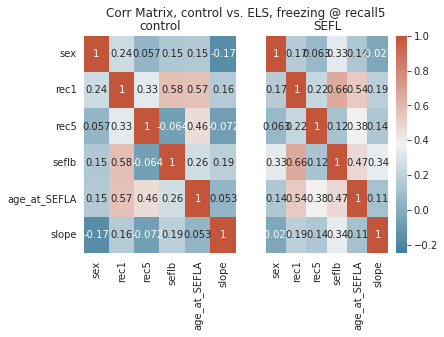

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True
                     )
fig.suptitle('Corr Matrix, control vs. ELS, freezing @ recall5')
df = clean_df[clean_df['group']=='Control']
cmap = sns.diverging_palette(230, 20, as_cmap=True)
vmax=1
vmin=-0.25
g1 = sns.heatmap(df.corr(), annot=True, cmap=cmap, ax=ax[0],
                 vmax=vmax, vmin=vmin, cbar=False)
ax[0].set_title('control')

df = clean_df[clean_df['group']=='SEFL']
g2 = sns.heatmap(df.corr(), annot=True, cmap=cmap, ax=ax[1],
                 vmax=vmax, vmin=vmin, cbar=True)
ax[1].set_title('SEFL')
# plt.savefig(join(save_dir, 'noELS', 'figures','multiReg',
#                  'OLS_corr_matrix_by_group_recall5.png'),
#                figsize=(11,5), transparent=True, dpi=300,
#                bbox_inches='tight')

In [ ]:
df_c = clean_df[clean_df['group']=='Control'].drop('group', axis=1)
y_c = df_c['rec5']
x_c = df_c.drop('rec5', axis=1)

mlr_c = sm.OLS(y_c, x_c).fit()
print(mlr_c.summary())

                                 OLS Regression Results                                
Dep. Variable:                   rec5   R-squared (uncentered):                   0.832
Model:                            OLS   Adj. R-squared (uncentered):              0.792
Method:                 Least Squares   F-statistic:                              20.82
Date:                Mon, 02 May 2022   Prob (F-statistic):                    1.72e-07
Time:                        04:09:52   Log-Likelihood:                         -88.317
No. Observations:                  26   AIC:                                      186.6
Df Residuals:                      21   BIC:                                      192.9
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

In [ ]:
df_c = clean_df[clean_df['group']=='SEFL'].drop('group', axis=1)
y_c = df_c['rec5']
x_c = df_c.drop('rec5', axis=1)

mlr_c = sm.OLS(y_c, x_c).fit()
print(mlr_c.summary())

                                 OLS Regression Results                                
Dep. Variable:                   rec5   R-squared (uncentered):                   0.726
Model:                            OLS   Adj. R-squared (uncentered):              0.689
Method:                 Least Squares   F-statistic:                              19.63
Date:                Mon, 02 May 2022   Prob (F-statistic):                    1.65e-09
Time:                        04:10:32   Log-Likelihood:                         -171.28
No. Observations:                  42   AIC:                                      352.6
Df Residuals:                      37   BIC:                                      361.3
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

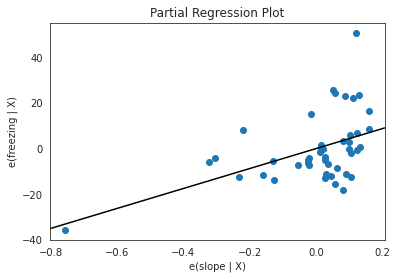

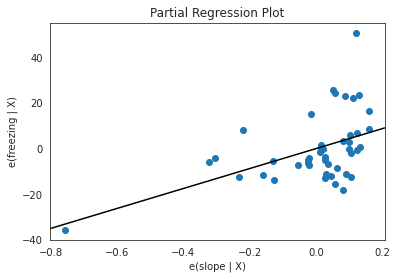

In [ ]:
sm.graphics.plot_partregress('freezing', 'slope',['age_at_SEFLA'],
                             data=df_s, obs_labels=False)

## Data Processing

In [ ]:
# Predictors: sex, age(to be calculated from DOB), learning rate
df_slope['age'] = df_slope.groupby(['cohort_id']).min()['date'] - df_slope['dob']

In [ ]:
temp = df_slope.groupby(['cohort_id'],as_index=True).min()['date'].reset_index()

In [ ]:
temp_dob = df_slope[['cohort_id', 'dob']].drop_duplicates()

In [ ]:
temp2 = temp.merge(temp_dob, on='cohort_id', how='inner')

In [ ]:
temp2['age'] = temp2['date'] - temp2['dob']

In [ ]:
temp3 = df_slope[['cohort_id', 'condition']].drop_duplicates()

In [ ]:
temp4 = df_slope[['cohort_id', 'freezing']].groupby(['cohort_id'],as_index=True).mean()['freezing']

In [ ]:
df_pred = temp2[['cohort_id', 'age']].merge(df_slope[['cohort_id', 'sex', 'slope_pre_shock06']].drop_duplicates(), on='cohort_id', how='inner')

In [ ]:
df_pred['sex'].replace(['male','female'],[0,1],inplace=True)

In [ ]:
df_pred = df_pred.merge(temp3, on='cohort_id', how='inner')

In [ ]:
df_pred = df_pred.merge(temp4, on='cohort_id', how='inner')

In [ ]:
df_pred['age'] = df_pred['age'].dt.days

In [ ]:
df_pred_c = df_pred.loc[df_pred['condition'] == 'control'].drop('condition',axis = 1).set_index('cohort_id')

In [ ]:
df_pred_s = df_pred.loc[df_pred['condition'] == 'SEFL'].drop('condition',axis = 1).set_index('cohort_id')

In [ ]:
df_pred_s

## Model: MLR

#### Control Group

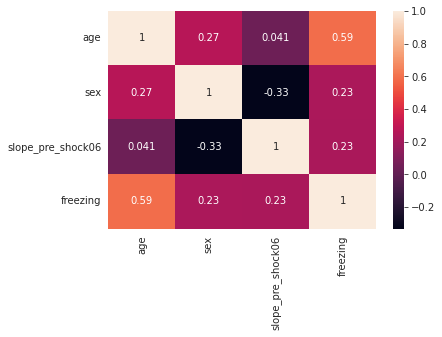

In [ ]:
sns.heatmap(df_pred_c.corr(), annot=True)

In [ ]:
y_c = df_pred_c['freezing']

In [ ]:
x_c = df_pred_c.drop('freezing',axis=1)

In [ ]:
x_c

,age,sex,slope_pre_shock06
cohort_id,,,
ptsd2_81,71,0,0.0541
ptsd2_82,71,0,0.1066
ptsd2_91,71,0,0.0187
ptsd2_92,71,0,0.0157
ptsd3_2,124,0,0.0627
ptsd3_6,75,0,0.0641
ptsd3_8,75,0,0.0026
ptsd4_61,76,0,0.1385
ptsd4_71,76,0,0.0170


In [ ]:
import statsmodels.api as sm
mlr_c = sm.OLS(y_c, x_c).fit()
print(mlr_c.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


                                 OLS Regression Results                                
Dep. Variable:               freezing   R-squared (uncentered):                   0.851
Model:                            OLS   Adj. R-squared (uncentered):              0.823
Method:                 Least Squares   F-statistic:                              30.44
Date:                Mon, 02 May 2022   Prob (F-statistic):                    7.58e-07
Time:                        00:03:12   Log-Likelihood:                         -58.288
No. Observations:                  19   AIC:                                      122.6
Df Residuals:                      16   BIC:                                      125.4
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))


#### Treatment Group

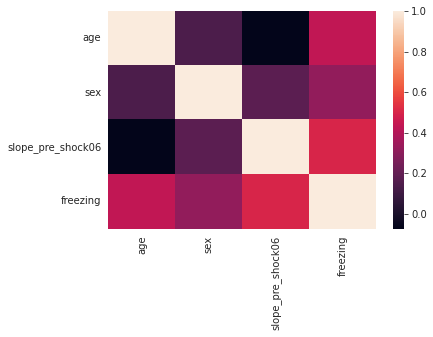

In [ ]:
sns.heatmap(df_pred_s.corr())

In [ ]:
y_s = df_pred_s['freezing']
x_s = df_pred_s.drop('freezing',axis=1)

In [ ]:
mlr_s = sm.OLS(y_s, x_s).fit()
print(mlr_s.summary())

                                 OLS Regression Results                                
Dep. Variable:               freezing   R-squared (uncentered):                   0.951
Model:                            OLS   Adj. R-squared (uncentered):              0.946
Method:                 Least Squares   F-statistic:                              218.2
Date:                Thu, 10 Mar 2022   Prob (F-statistic):                    2.85e-22
Time:                        20:51:29   Log-Likelihood:                         -124.06
No. Observations:                  37   AIC:                                      254.1
Df Residuals:                      34   BIC:                                      259.0
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------